In [ ]:
# import des bibliothèques necessaires pour le projet
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import en_core_web_sm
from sklearn.metrics import confusion_matrix
import tensorflow as tf 
import re
import string
from tensorflow.keras import Sequential
from nltk.probability import FreqDist
from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.metrics import recall_score, precision_score
import tensorflow as tf 
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, GRU, LSTM
from sklearn.metrics import f1_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.metrics import recall_score, precision_score
from wordcloud import WordCloud,ImageColorGenerator ,STOPWORDS
import nltk
nltk.download('stopwords')
from function_clean import *
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D, Dropout, Bidirectional, SimpleRNN, GRU, LSTM, LeakyReLU

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Importation des fichiers Train.csv, test.csv et sample_submission.csv depuis le répertoire personnel github

! wget https://raw.githubusercontent.com/soufianeze/MachineLearning2/main/train.csv
! wget https://raw.githubusercontent.com/soufianeze/MachineLearning2/main/test.csv
! wget https://raw.githubusercontent.com/soufianeze/MachineLearning2/main/sample_submission.csv


--2022-07-21 17:24:34--  https://raw.githubusercontent.com/soufianeze/MachineLearning2/main/train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 987712 (965K) [text/plain]
Saving to: ‘train.csv’

train.csv           100%[===================>] 964.56K  --.-KB/s    in 0.05s   

2022-07-21 17:24:34 (19.8 MB/s) - ‘train.csv’ saved [987712/987712]

--2022-07-21 17:24:34--  https://raw.githubusercontent.com/soufianeze/MachineLearning2/main/test.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 420783 (411K) [text/plain]
Saving to

#Exploration des Données

In [ ]:
# Stocker les deuc fichiers test et train dans un Dataframe et afficher les 10 premiers lignes de la dataframe (Train)
test_df =pd.read_csv("test.csv", sep = ',', header = 0)
train_df =pd.read_csv("train.csv", sep = ',', header = 0)
df_sample_submission = pd.read_csv("sample_submission.csv", sep = ',', header = 0)
train_df.head(10)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


In [ ]:
# Fréquence de la variable target
train_df['target'].value_counts(normalize=True)

0    0.57034
1    0.42966
Name: target, dtype: float64

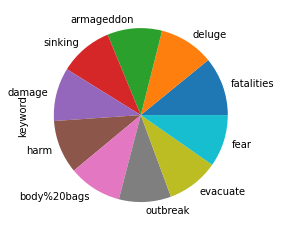

In [ ]:
# Les 10 premiers keyword valeurs dans le Train
train_df['keyword'].value_counts()[:10].plot.pie();

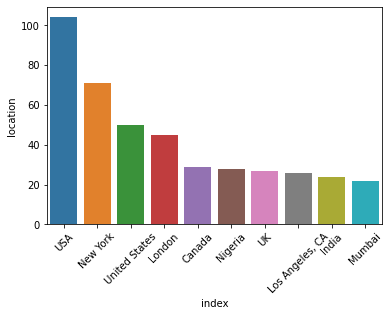

In [ ]:
# Les 10 Premiers LOCATIONS qui ont plus de twetes
top_location = train_df['location'].value_counts().reset_index()
top10_location = top_location.iloc[:10]
ax = sns.barplot(x="index", y="location", data=top10_location)
plt.xticks(rotation=45);

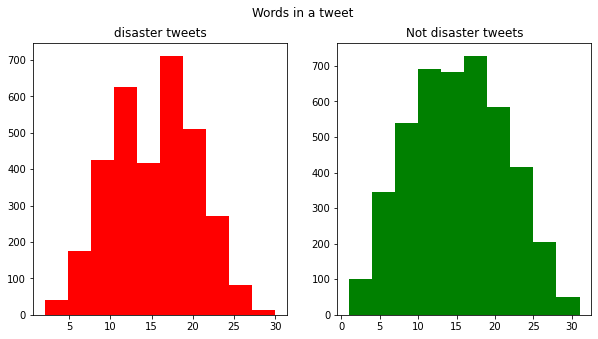

In [ ]:
# Répartition du nombre de mots par nature de tweet (disaster/not disaster)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=train_df[train_df['target']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(tweet_len,color='red')
ax1.set_title('disaster tweets')

tweet_len=train_df[train_df['target']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(tweet_len,color='green')
ax2.set_title('Not disaster tweets')
fig.suptitle('Words in a tweet')
plt.show()

In [ ]:
# Afficher les 50 premiers éléments de la colonne 'text' 
for i in range(50):
  print(train_df['text'][i])

Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
Forest fire near La Ronge Sask. Canada
All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected
13,000 people receive #wildfires evacuation orders in California 
Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school 
#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires
#flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas
I'm on top of the hill and I can see a fire in the woods...
There's an emergency evacuation happening now in the building across the street
I'm afraid that the tornado is coming to our area...
Three people died from the heat wave so far
Haha South Tampa is getting flooded hah- WAIT A SECOND I LIVE IN SOUTH TAMPA WHAT AM I GONNA DO WHAT AM I GONNA DO FVCK #flooding
#raining #flooding #Florida 

#Pre-processing

In [ ]:
train_df["text"] = train_df["text"].map(clean_dataset)
train_df["List of Words"] = train_df["text"].map(Convert)
test_df["text"] = test_df["text"].map(clean_dataset)
test_df["List of Words"] = test_df["text"].map(Convert)

In [ ]:
stop_words = nltk.corpus.stopwords.words("english")
disaster_tweets = train_df[train_df["target"]==1]["text"].tolist()
non_disaster_tweets = train_df[train_df["target"]==0]["text"].to_list()

In [ ]:
disaster_tweets_df = pd.DataFrame(disaster_tweets , columns = ["text"])
disaster_tweets_df["List of Words"] = disaster_tweets_df["text"].map(Convert)

non_disaster_tweets_df = pd.DataFrame(non_disaster_tweets , columns = ["text"])
non_disaster_tweets_df["List of Words"] = non_disaster_tweets_df["text"].map(Convert)

In [ ]:
disaster_words = disaster_tweets_df["List of Words"]
disaster_allwords = []
for wordlist in disaster_words:
    for disaster_word in wordlist:
        if disaster_word not in stop_words:
            disaster_allwords.append(disaster_word)


non_disaster_words = non_disaster_tweets_df["List of Words"]
non_disaster_allwords = []
for wordlist in non_disaster_words:
    for non_disaster_word in wordlist:
        if non_disaster_word not in stop_words:
            non_disaster_allwords.append(non_disaster_word)

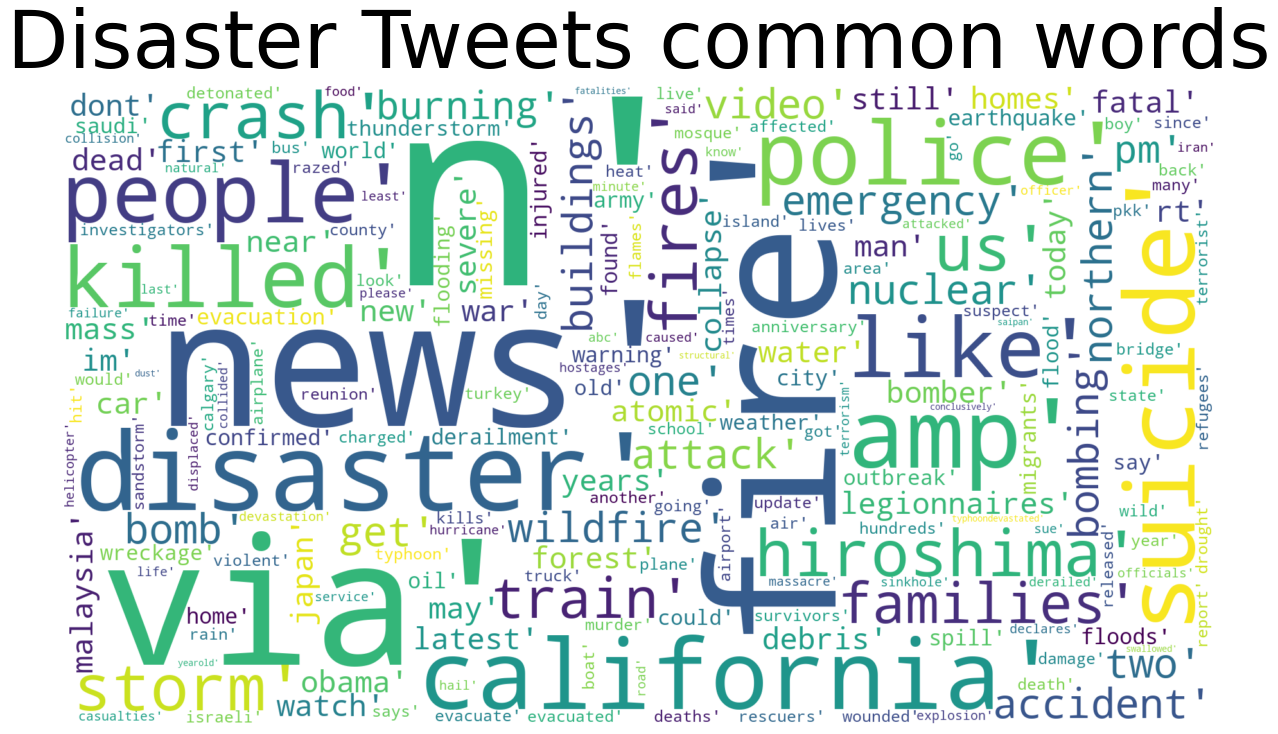

In [ ]:
mostcommon = FreqDist(disaster_allwords).most_common(2000)
wordcloud = WordCloud(width=1800, height=1000, background_color='white').generate(str(mostcommon))
fig = plt.figure(figsize=(30,10), facecolor='white')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Disaster Tweets common words', fontsize=80)
plt.tight_layout(pad=0)
plt.show()

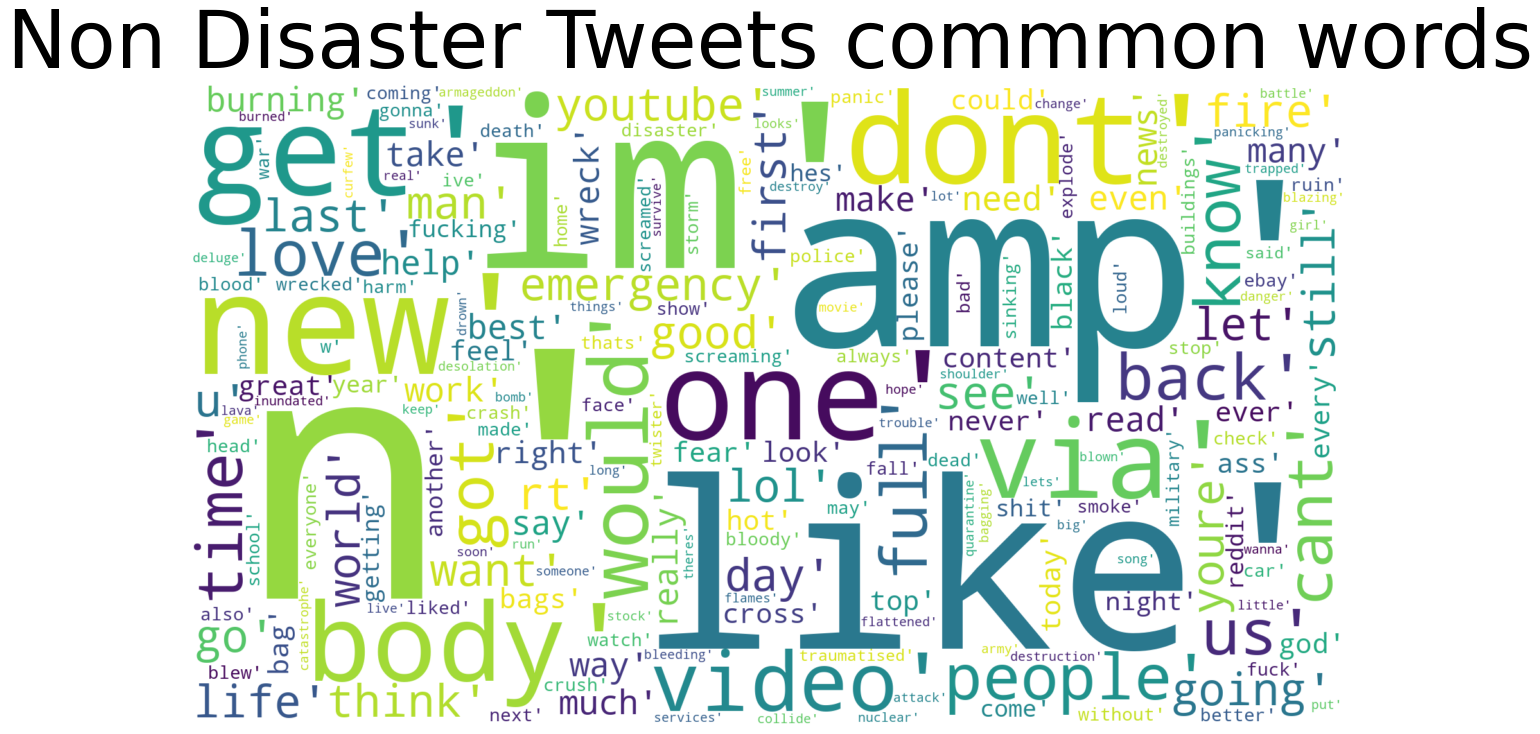

In [ ]:
mostcommon = FreqDist(non_disaster_allwords).most_common(2000)
wordcloud = WordCloud(width=1800, height=1000, background_color='white').generate(str(mostcommon))
fig = plt.figure(figsize=(30,10), facecolor='white')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Non Disaster Tweets commmon words', fontsize=80)
plt.tight_layout(pad=0)
plt.show()

In [ ]:
# Afficher les 50 premiers éléments de la colonne 'text' après le pre traitement du texte
for i in range(50):
  print(train_df['text'][i])

our deeds are the reason of this earthquake may allah forgive us all
forest fire near la ronge sask canada
all residents asked to shelter in place are being notified by officers no other evacuation or shelter in place orders are expected
 people receive wildfires evacuation orders in california 
just got sent this photo from ruby alaska as smoke from wildfires pours into a school 
rockyfire update  california hwy  closed in both directions due to lake county fire  cafire wildfires
flood disaster heavy rain causes flash flooding of streets in manitou colorado springs areas
im on top of the hill and i can see a fire in the woods
theres an emergency evacuation happening now in the building across the street
im afraid that the tornado is coming to our area
three people died from the heat wave so far
haha south tampa is getting flooded hah wait a second i live in south tampa what am i gonna do what am i gonna do fvck flooding
raining flooding florida tampabay tampa  or  days ive lost count 

In [ ]:
nlp = en_core_web_sm.load()

In [ ]:
# Tokenisation et supression des mots qui existent dans  stopwords

train_df["text_tokenized"] = train_df["text"].apply(lambda x: [token.lemma_ for token in nlp(x) if token.text not in STOP_WORDS])
train_df.head()

,id,keyword,location,text,target,List of Words,text_tokenized
0,1,NaN,NaN,our deeds are the reason of this earthquake ma...,1,"[our, deeds, are, the, reason, of, this, earth...","[deed, reason, earthquake, allah, forgive]"
1,4,NaN,NaN,forest fire near la ronge sask canada,1,"[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, ronge, sask, canada]"
2,5,NaN,NaN,all residents asked to shelter in place are be...,1,"[all, residents, asked, to, shelter, in, place...","[resident, ask, shelter, place, notify, office..."
3,6,NaN,NaN,people receive wildfires evacuation orders in...,1,"[, people, receive, wildfires, evacuation, ord...","[ , people, receive, wildfire, evacuation, ord..."
4,7,NaN,NaN,just got sent this photo from ruby alaska as s...,1,"[just, got, sent, this, photo, from, ruby, ala...","[got, send, photo, ruby, alaska, smoke, wildfi..."


In [ ]:
# DeTokenisation du texte déjè tokenisé dans nlp_ready
detokenized_doc = []
for sentence in train_df["text_tokenized"]:
    t = ' '.join(sentence)
    detokenized_doc.append(t)

train_df['nlp_ready'] = detokenized_doc
train_df.head()

,id,keyword,location,text,target,List of Words,text_tokenized,nlp_ready
0,1,NaN,NaN,our deeds are the reason of this earthquake ma...,1,"[our, deeds, are, the, reason, of, this, earth...","[deed, reason, earthquake, allah, forgive]",deed reason earthquake allah forgive
1,4,NaN,NaN,forest fire near la ronge sask canada,1,"[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, ronge, sask, canada]",forest fire near la ronge sask canada
2,5,NaN,NaN,all residents asked to shelter in place are be...,1,"[all, residents, asked, to, shelter, in, place...","[resident, ask, shelter, place, notify, office...",resident ask shelter place notify officer evac...
3,6,NaN,NaN,people receive wildfires evacuation orders in...,1,"[, people, receive, wildfires, evacuation, ord...","[ , people, receive, wildfire, evacuation, ord...",people receive wildfire evacuation order cal...
4,7,NaN,NaN,just got sent this photo from ruby alaska as s...,1,"[just, got, sent, this, photo, from, ruby, ala...","[got, send, photo, ruby, alaska, smoke, wildfi...",got send photo ruby alaska smoke wildfire pour...


In [ ]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=1000) # instanciate the tokenizer

tokenizer.fit_on_texts(train_df["nlp_ready"])
train_df["text_encoded"] = tokenizer.texts_to_sequences(train_df['nlp_ready'])
train_df["len_text"] = train_df["text_encoded"].apply(lambda x: len(x))
train_df = train_df[train_df["len_text"]!=0]

In [ ]:
# Padding
text_pad_train = tf.keras.preprocessing.sequence.pad_sequences(train_df['text_encoded'], padding="post")

In [ ]:
# Traiter la variable Target 
full_ds = tf.data.Dataset.from_tensor_slices((text_pad_train, train_df['target'].values))

In [ ]:
# Train Test Split
TAKE_SIZE = int(0.7 * train_df.shape[0])

train_data = full_ds.take(TAKE_SIZE).shuffle(TAKE_SIZE)
train_data = train_data.batch(64)

test_data = full_ds.skip(TAKE_SIZE)
test_data = test_data.batch(64)

In [ ]:
 # Regardons un batch 
for text_encoded, target in train_data.take(1):
  print(text_encoded, target)

tf.Tensor(
[[877   3   0 ...   0   0   0]
 [191 223  93 ...   0   0   0]
 [381  26 436 ...   0   0   0]
 ...
 [  8 367 549 ...   0   0   0]
 [ 53  72 154 ...   0   0   0]
 [150   0   0 ...   0   0   0]], shape=(64, 18), dtype=int32) tf.Tensor(
[0 1 0 0 1 0 1 0 0 0 1 0 0 0 1 1 0 0 1 1 1 0 1 1 1 1 1 1 0 0 0 1 1 0 1 1 0
 1 1 1 1 0 0 0 0 0 0 1 0 1 0 0 0 1 1 0 0 0 1 1 0 0 0 0], shape=(64,), dtype=int64)


# Modélisation 

In [ ]:
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D

In [ ]:
vocabulary_size = 10000

In [ ]:
embedding_dim=16 # the dimensionality of the representation space

vocab_size = tokenizer.num_words # the number of words in the vocabulary
model = Sequential([
  Embedding(vocab_size, embedding_dim, name="embedding"), # the embedding layer
  # the input dim needs to be equal to the size of the vocabulary + 1 (because of
  # the zero padding)
  GlobalAveragePooling1D(), # this will pick the average for every word in the sentence
  # along each dimension of the representation space.
  Dense(16, activation='relu'), # a dense layer
  Dense(1, activation="sigmoid") # the prediction layer
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          16000     
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 16)                272       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 16,289
Trainable params: 16,289
Non-trainable params: 0
_________________________________________________________________


In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs2")

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [ ]:
model.fit(
    train_data,
    validation_data=test_data,
    epochs=20,
    callbacks=[tensorboard_callback])

Epoch 1/20
83/83 [==============================] - 1s 5ms/step - loss: 0.6814 - accuracy: 0.5683 - val_loss: 0.6777 - val_accuracy: 0.5566
Epoch 2/20
83/83 [==============================] - 0s 4ms/step - loss: 0.6539 - accuracy: 0.5974 - val_loss: 0.6450 - val_accuracy: 0.6019
Epoch 3/20
83/83 [==============================] - 0s 3ms/step - loss: 0.5848 - accuracy: 0.7180 - val_loss: 0.5764 - val_accuracy: 0.7472
Epoch 4/20
83/83 [==============================] - 0s 3ms/step - loss: 0.5001 - accuracy: 0.7926 - val_loss: 0.5234 - val_accuracy: 0.7635
Epoch 5/20
83/83 [==============================] - 0s 3ms/step - loss: 0.4466 - accuracy: 0.8107 - val_loss: 0.4966 - val_accuracy: 0.7688
Epoch 6/20
83/83 [==============================] - 0s 3ms/step - loss: 0.4178 - accuracy: 0.8216 - val_loss: 0.4876 - val_accuracy: 0.7701
Epoch 7/20
83/83 [==============================] - 0s 3ms/step - loss: 0.4015 - accuracy: 0.8271 - val_loss: 0.4845 - val_accuracy: 0.7776
Epoch 8/20
83/83 [==

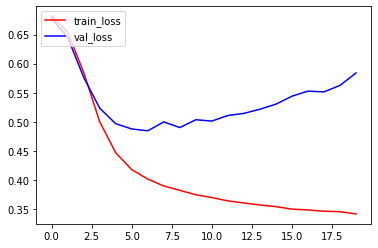

In [ ]:
plt.plot(model.history.history["loss"], c="r", label="train_loss")
plt.plot(model.history.history["val_loss"], c="b", label="val_loss")
plt.legend(loc="upper left")
plt.show()

In [ ]:
embedding_dim=16 # the dimensionality of the representation space

vocab_size = tokenizer.num_words # the number of words in the vocabulary
model = Sequential([
  Embedding(vocab_size, embedding_dim, name="embedding"), # the embedding layer
  # the input dim needs to be equal to the size of the vocabulary + 1 (because of
  # the zero padding)
  GlobalAveragePooling1D(), # this will pick the average for every word in the sentence
  # along each dimension of the representation space.
  Dropout(0.5),
  Dense(16, activation='relu'),
  Dense(16, activation='relu'), # a dense layer
  Dense(1, activation="sigmoid") # the prediction layer
])

model.summary()

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

model2 = model.fit(
    train_data,
    validation_data=test_data,
    epochs=20,
    callbacks=[tensorboard_callback])

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          16000     
                                                                 
 global_average_pooling1d_3   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout_5 (Dropout)         (None, 16)                0         
                                                                 
 dense_13 (Dense)            (None, 16)                272       
                                                                 
 dense_14 (Dense)            (None, 16)                272       
                                                                 
 dense_15 (Dense)            (None, 1)                 17        
                                                      

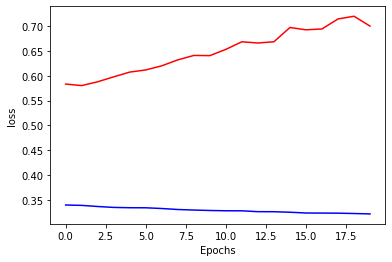

In [ ]:
import matplotlib.pyplot as plt

# Visualization of the training process on the loss function 
plt.plot(model2.history["loss"], color="b")
plt.plot(model2.history["val_loss"], color="r")
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.show()

In [ ]:
embedding_dim=64

model3 = Sequential([
  Embedding(vocabulary_size, embedding_dim, name="embedding", mask_zero=False, input_length = text_pad_train.shape[1]),
  GRU(units=64, return_sequences=True), # maintains the sequential nature
  GRU(units=64, return_sequences=True), # maintains the sequential nature
  GRU(units=64, return_sequences=True), # maintains the sequential nature
  GRU(units=32, return_sequences=False), # returns the last output
  Dense(1, activation='sigmoid')
])


model3.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

model3 = model3.fit(train_data, validation_data = test_data, epochs = 20) 

Epoch 1/20
83/83 [==============================] - 17s 97ms/step - loss: 0.6360 - accuracy: 0.6253 - val_loss: 0.5192 - val_accuracy: 0.7530
Epoch 2/20
83/83 [==============================] - 6s 75ms/step - loss: 0.4402 - accuracy: 0.8075 - val_loss: 0.5149 - val_accuracy: 0.7420
Epoch 3/20
83/83 [==============================] - 6s 74ms/step - loss: 0.4023 - accuracy: 0.8294 - val_loss: 0.5358 - val_accuracy: 0.7318
Epoch 4/20
83/83 [==============================] - 6s 75ms/step - loss: 0.3825 - accuracy: 0.8437 - val_loss: 0.5398 - val_accuracy: 0.7406
Epoch 5/20
83/83 [==============================] - 6s 73ms/step - loss: 0.3697 - accuracy: 0.8488 - val_loss: 0.5913 - val_accuracy: 0.7217
Epoch 6/20
83/83 [==============================] - 6s 75ms/step - loss: 0.3634 - accuracy: 0.8537 - val_loss: 0.5925 - val_accuracy: 0.7133
Epoch 7/20
83/83 [==============================] - 6s 73ms/step - loss: 0.3576 - accuracy: 0.8530 - val_loss: 0.5734 - val_accuracy: 0.7288
Epoch 8/20
8

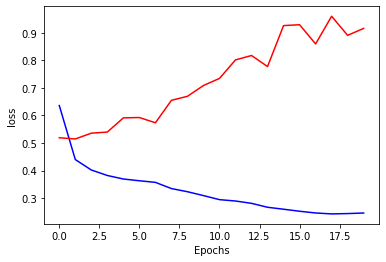

In [ ]:
import matplotlib.pyplot as plt

# Visualization of the training process on the loss function 
plt.plot(model3.history["loss"], color="b")
plt.plot(model3.history["val_loss"], color="r")
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.show()

In [ ]:
predict = model.predict(test_data)
predict_labels = np.argmax(predict, axis=1)

In [ ]:
for i in range(len(predict_labels)):
  predict_labels[i] = predict_labels[i]

ids = list(df_sample_submission['id'])

submission_dic = {"id":ids, "target":predict_labels}
submission_df = pd.DataFrame.from_dict(submission_dic,orient='index')
submission_df.to_csv("kaggle_01.csv", index = False)